In [152]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [156]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        yield name
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

matplotlib==3.5.2
numpy==1.21.5
pandas==1.4.4
seaborn==0.11.2


## Loading dataset

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("customer_churn.csv")
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5892,2709-UQGNP,Male,0,No,No,10,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,51.65,524.5,No
984,8165-ZJRNM,Female,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.75,1679.25,No
3332,7593-XFKDI,Male,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,46.30,46.3,Yes
1776,5605-XNWEN,Male,1,Yes,No,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),25.00,1802.55,No
1042,7296-PIXQY,Female,0,Yes,Yes,14,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,70.20,1046.5,No


In [4]:
df.drop(columns = ['customerID'], inplace=True)

## Checking datatypes and handling categorical variables

In [5]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

**Handling Object type columns**

In [6]:
for column in df:
    if df[column].dtypes=='object':
        print(f'{column}: {df[column].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


In [7]:
df.replace({'Yes': 1,'No': 0, 'No internet service':0, 'No phone service':0}, inplace=True)

In [8]:
for column in df:
    if df[column].dtypes=='object':
        print(f'{column}: {df[column].unique()}')

gender: ['Female' 'Male']
InternetService: ['DSL' 'Fiber optic' 0]
Contract: ['Month-to-month' 'One year' 'Two year']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']


In [9]:
df.replace({'Male': 1,'Female': 0}, inplace=True)

In [10]:
df = pd.get_dummies(data=df, columns=['InternetService','Contract','PaymentMethod'])

In [11]:
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                                object
Churn                                        int64
InternetService_0                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic    

In [12]:
df.TotalCharges.unique

<bound method Series.unique of 0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object>

**Total Charges Column seems to be all float but has dtype object**

In [13]:
df.TotalCharges.isnull().sum()

0

In [15]:
df.TotalCharges = pd.to_numeric(df.TotalCharges,errors='coerce')

In [16]:
df.TotalCharges.isnull().sum()

11

**Total Charges converter to a numeric column and rows with non numeric value in TotalCharges changed to null using error="coerce"**

In [17]:
df.dropna(inplace=True)
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_0                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic    

In [18]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_0,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,1,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,1,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,0,1,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,1,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,0,1,1,1,1,1,84.80,1990.50,0,0,1,0,0,1,0,0,0,0,1
7039,0,0,1,1,72,1,1,0,1,1,0,1,1,1,103.20,7362.90,0,0,0,1,0,1,0,0,1,0,0
7040,0,0,1,1,11,0,0,1,0,0,0,0,0,1,29.60,346.45,0,0,1,0,1,0,0,0,0,1,0
7041,1,1,1,0,4,1,1,0,0,0,0,0,0,1,74.40,306.60,1,0,0,1,1,0,0,0,0,0,1


## Scalling tenure, monthlyCharges and TotalCharges columns

In [19]:
cols = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[cols] = scaler.fit_transform(df[cols])

In [20]:
for col in df:
    print(f'{col}: {df[col].unique()}')

gender: [0 1]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

**Data Visualization**

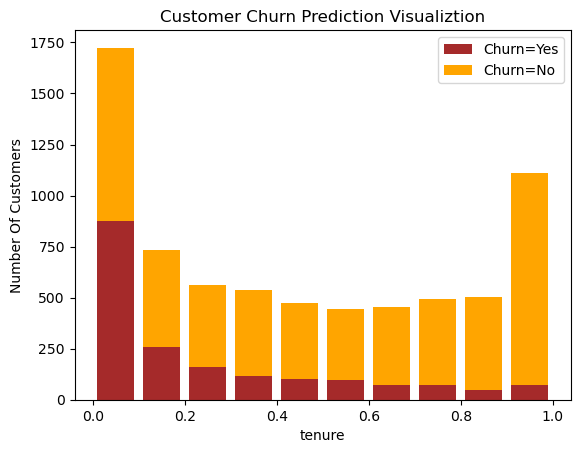

In [22]:
tenure_churn_no = df[df.Churn==0].tenure
tenure_churn_yes = df[df.Churn==1].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")


plt.hist([tenure_churn_yes, tenure_churn_no], stacked = True, rwidth=0.8, color=['brown','orange'], label=['Churn=Yes','Churn=No'])
plt.legend()

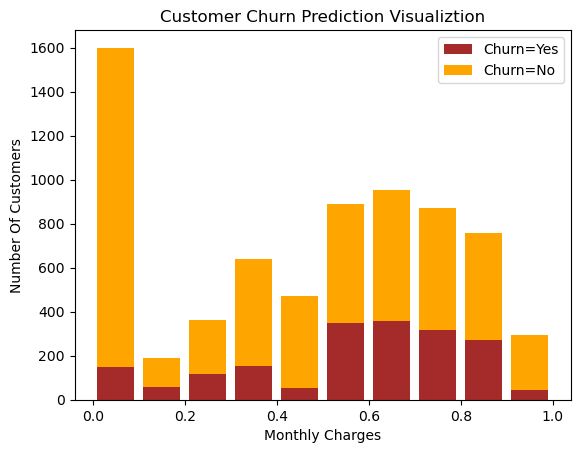

In [23]:
mc_churn_no = df[df.Churn==0].MonthlyCharges      
mc_churn_yes = df[df.Churn==1].MonthlyCharges      

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([mc_churn_yes, mc_churn_no], stacked = True, rwidth=0.8, color=['brown','orange'], label=['Churn=Yes','Churn=No'])
plt.legend()

## Prediction Model

In [41]:
X = df.drop(columns = ['Churn'])
y = df['Churn']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [46]:
neigh = KNeighborsClassifier(n_neighbors=5)

In [47]:
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [48]:
y_pred = neigh.predict(X_test)

In [55]:
y_pred[:6]

array([0, 0, 0, 1, 1, 0])

In [56]:
y_test[:6].values

array([0, 0, 1, 1, 1, 1])

In [57]:
neigh.predict_proba(X_test[:6])

array([[0.8, 0.2],
       [0.6, 0.4],
       [1. , 0. ],
       [0.4, 0.6],
       [0.4, 0.6],
       [0.6, 0.4]])

In [59]:
target_names = ['No', 'Yes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          No       0.81      0.84      0.83       999
         Yes       0.58      0.52      0.55       408

    accuracy                           0.75      1407
   macro avg       0.69      0.68      0.69      1407
weighted avg       0.74      0.75      0.75      1407



In [76]:
y_test.shape, y_test[y_test==0].shape, y_test[y_test==1].shape

((1407,), (999,), (408,))

In [64]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[842, 157],
       [195, 213]])

In [68]:
np.sum(cf_matrix, axis=1)

array([999, 408])

In [74]:
np.transpose(cf_matrix)/np.sum(cf_matrix, axis=1)

array([[0.84284284, 0.47794118],
       [0.15715716, 0.52205882]])

<AxesSubplot:>

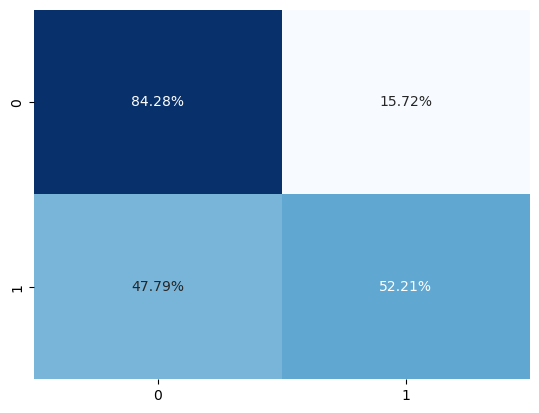

In [75]:
sns.heatmap(np.transpose(np.transpose(cf_matrix)/np.sum(cf_matrix, axis=1)), annot=True, 
            fmt='.2%', cmap='Blues', cbar=False)

**Balancing classes**

In [43]:
len(df[df.Churn==0]), len(df[df.Churn==1])

(5163, 1869)

In [80]:
len(y[y==0]), len(y[y==1])

(5163, 1869)

In [125]:
# Since the classes are imbalanced we use smote
sm = SMOTE(random_state=42)

In [126]:
Xs, ys = sm.fit_resample(X, y)

In [127]:
len(ys[ys==0]), len(ys[ys==1])

(5163, 5163)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=32)

In [129]:
neigh2 = KNeighborsClassifier(n_neighbors=5)
neigh2.fit(X_train, y_train)

KNeighborsClassifier()

In [130]:
y_pred = neigh2.predict(X_test)
y_pred[:6]

array([1, 1, 0, 1, 1, 0])

In [131]:
y_test[:6].values

array([1, 1, 1, 1, 1, 1])

In [132]:
neigh2.predict_proba(X_test[:6])

array([[0.2, 0.8],
       [0. , 1. ],
       [0.8, 0.2],
       [0. , 1. ],
       [0. , 1. ],
       [0.6, 0.4]])

In [133]:
target_names = ['No', 'Yes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          No       0.85      0.71      0.77      1013
         Yes       0.76      0.88      0.82      1053

    accuracy                           0.80      2066
   macro avg       0.81      0.80      0.80      2066
weighted avg       0.81      0.80      0.80      2066



<AxesSubplot:>

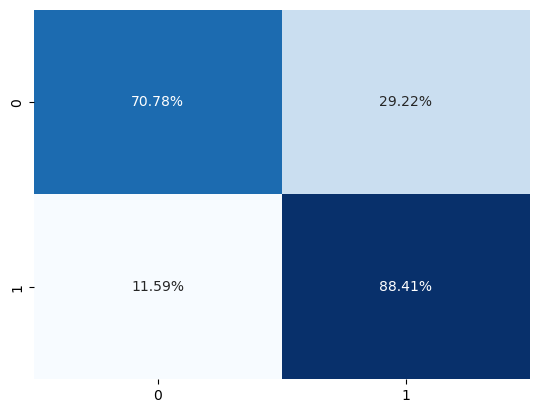

In [134]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(np.transpose(np.transpose(cf_matrix)/np.sum(cf_matrix, axis=1)), annot=True, 
            fmt='.2%', cmap='Blues', cbar=False)

In [ ]:
# The results after balancing classes have imporoved significantly as compared to before

**Removing columns with low corelation with the the target column**

In [27]:
df_corr = abs(df.corr())

<AxesSubplot:>

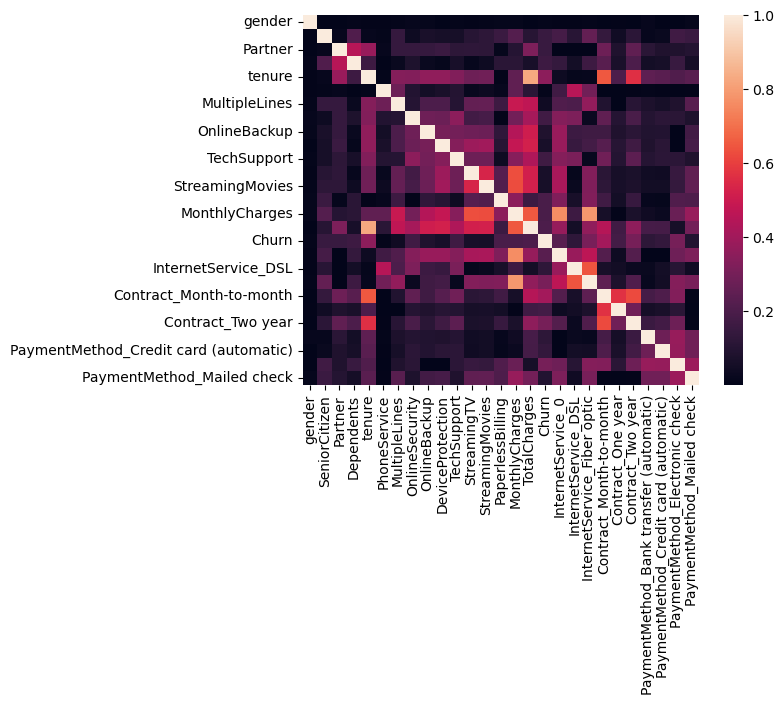

In [29]:
sns.heatmap(df_corr)

In [30]:
type(df_corr)

pandas.core.frame.DataFrame

In [93]:
df_corr[df_corr.Churn > 0.3].index.values

array(['tenure', 'Churn', 'InternetService_Fiber optic',
       'Contract_Month-to-month', 'Contract_Two year',
       'PaymentMethod_Electronic check'], dtype=object)

In [90]:
cols_to_drop = df_corr[df_corr.Churn < 0.3].index.values

In [91]:
df2 = df.drop(columns=cols_to_drop)

In [92]:
df2

,tenure,Churn,InternetService_Fiber optic,Contract_Month-to-month,Contract_Two year,PaymentMethod_Electronic check
0,0.000000,0,0,1,0,1
1,0.464789,0,0,0,0,0
2,0.014085,1,0,1,0,0
3,0.619718,0,0,0,0,0
4,0.014085,1,1,1,0,1
...,...,...,...,...,...,...
7038,0.323944,0,0,0,0,0
7039,1.000000,0,1,0,0,0
7040,0.140845,0,0,1,0,1
7041,0.042254,1,1,1,0,0


In [94]:
X2 = df2.drop(columns=['Churn'])
y2 = df2.Churn

In [95]:
len(y[y==0]), len(y[y==1])

(5163, 1869)

In [96]:
# Balancing classes
sm = SMOTE(random_state=42)
Xs2, ys2 = sm.fit_resample(X2, y2)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(Xs2, ys2, test_size=0.2, random_state=32, stratify=ys2)

In [149]:
neigh3 = KNeighborsClassifier(n_neighbors=5)
neigh3.fit(X_train, y_train)
y_pred = neigh3.predict(X_test)

In [150]:
target_names = ['No', 'Yes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          No       0.79      0.73      0.76      1033
         Yes       0.75      0.80      0.78      1033

    accuracy                           0.77      2066
   macro avg       0.77      0.77      0.77      2066
weighted avg       0.77      0.77      0.77      2066



<AxesSubplot:>

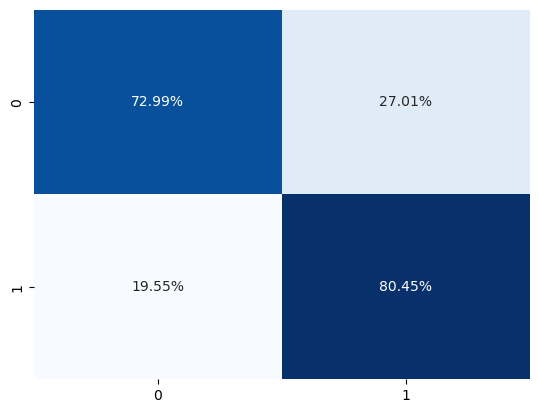

In [151]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(np.transpose(np.transpose(cf_matrix)/np.sum(cf_matrix, axis=1)), annot=True, 
            fmt='.2%', cmap='Blues', cbar=False)

In [ ]:
# The computation has decreased significantly but the result accuracy has fallen a little